# Capture

In [1]:
push!(LOAD_PATH,"../src/")

using Potential: potential
using Plots
using LsqFit
using CSV, DataFrames # consider CSVFiles

# $d^0 \rightarrow DX^{-}$

In [17]:
# GaAs
E_gap = 1.8 # eV
ΔE = 0.825  # eV
NQ = 3000
Qi = -1
Qf = 30
Q = range(Qi, stop=Qf, length=NQ)


-1.0:0.010336778926308769:30.0

In [18]:
pot_d0 = potential()
pot_d0.QE_data = names!(CSV.read("Potential_d0.csv"; allowmissing=:none), [:Q, :E])
pot_d0.E0 = 1.8#$E_gap
# pot_d0.QE_data.E .+= - minimum(pot_d0.QE_data.E) + pot_d0.E0
pot_d0.Q = Q
pot_d0.nev = 10
pot_d0.p0 = [0.1, 0.1, 0.1, 0.1, 0.1]

5-element Array{Float64,1}:
 0.1
 0.1
 0.1
 0.1
 0.1

[2.10766, 0.250771, 0.0193253, -0.566625, 3.53226]

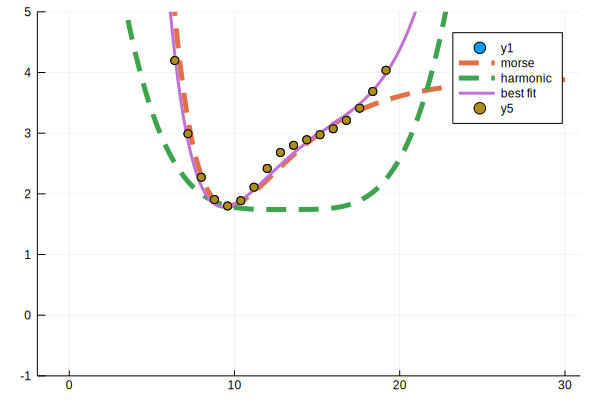

In [21]:
function morse_harmonic(x, coeffs; param)
    E0 = param["E0"]
    Q0 = param["Q0"]
    r0 = coeffs[4]
    r1 = coeffs[5]
    morse = coeffs[1]*(1-exp.(-coeffs[2].*(x-Q0-r0))).^2 .- coeffs[1]*(1-exp.(-coeffs[2]*r0)).^2
    harmonic = coeffs[3]^2*(x-Q0-r1).^4 -coeffs[3]^2*r1^4
    return morse + harmonic + E0
end

pot_d0.func_type = "morse_harmonic"
pot=pot_d0
E_CUT = 5
func = @eval $(Symbol(pot.func_type))

pot.params["E0"] = pot.E0
pot.params["Q0"] = pot.QE_data.Q[findmin(pot.QE_data.E)[2]]
params = pot.params

e_cut_ind = pot.QE_data.E .< E_CUT

fit = curve_fit((x,p) -> func.(x, Ref(p); param=params), 
                pot.QE_data.Q[e_cut_ind], pot.QE_data.E[e_cut_ind], 
                [3, 0.2, 0.01, -2, 5])

print(fit.param)
# pot.Q = Q
# pot.E = func.(Q, Ref([1 0.21 1 0.21]); param=params)
pot.func = x -> func.(x, Ref(fit.param); param=params)

# # plot function
scatter(pot.QE_data.Q, pot.QE_data.E)
plot!(pot.Q, func.(Q, Ref([2.10764, 0.250771, 0, -0.0052927, 0.0177464]); param=params), lw=5, ls=:dash, label="morse")
plot!(pot.Q, func.(Q, Ref([0, 0.250771, 0.0193245, -0.566561, 3.53214]); param=params), lw=5, ls=:dash, label="harmonic")
# plot!(pot.Q, func.(Q, Ref([1.2 0.25 0.0001]); param=params), lw=4, label="mo-ha")
E = pot.func.(Q)
plot!(pot.Q, E, label="best fit", lw=3)

scatter!(pot.QE_data.Q[e_cut_ind], pot.QE_data.E[e_cut_ind])



# # plot data
ylims!(-1,5)

Dict{String,Number}("E0"=>0.0,"Q0"=>9.58512)[0.00484315, 310.037, -139.217, -0.000309023, -257.639]

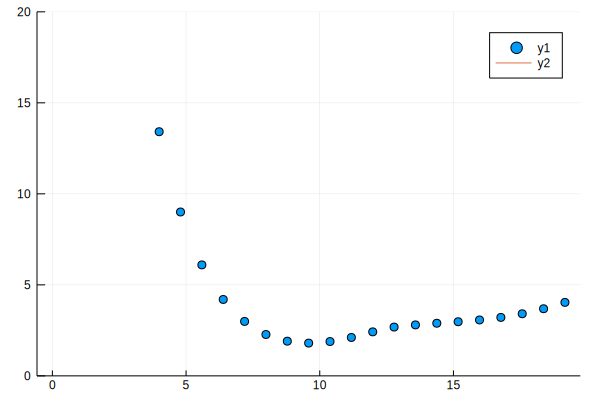

In [5]:
function lj_harmonic(x, coeffs; param)
    E0 = param["E0"]
    Q0 = param["Q0"]
    inv_r = coeffs[2]./(x-coeffs[3])
    ls = coeffs[1] .* (inv_r^12 - 2 .*inv_r^6) + coeffs[1]
    harmonic = coeffs[4]*(x .- coeffs[5]).^2
    return ls + harmonic + E0
end

# pot_d0.func_type = "harmonic"
pot_d0.func_type = "morse_harmonic"
pot_d0.func_type = "lj_harmonic"
pot=pot_d0
func = @eval $(Symbol(pot.func_type))

pot.params["E0"] = pot.E0
pot.params["Q0"] = pot.QE_data.Q[findmin(pot.QE_data.E)[2]]
params = pot.params

print(params)
fit = curve_fit((x,p) -> func.(x, Ref(p); param=params), pot.QE_data.Q, pot.QE_data.E, [5, 16, -5, 0.6, 19])

print(fit.param)
# pot.Q = Q
# pot.E = func.(Q, Ref([1 0.21 1 0.21]); param=params)
pot.func = x -> func.(x, Ref(fit.param); param=params)

# # plot function
scatter(pot.QE_data.Q, pot.QE_data.E)
# plot!(pot.Q, func.(Q, Ref([5.62675e-17, 9.18867, 0.01]); param=params), lw=5, label="morse")
# plot!(pot.Q, func.(Q, Ref([0 0.3 0.01]); param=params), lw=4, label="harmonic")
# plot!(pot.Q, func.(Q, Ref([1.2 0.25 0.0001]); param=params), lw=4, label="mo-ha")
E = pot.func.(Q)
plot!(pot.Q, E)



# # plot data
ylims!(0,20)